In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 11 14:32:21 2018

@author: dace
"""

from math import sqrt,factorial,exp
import numpy as np
from sympy.physics.wigner import wigner_3j, wigner_6j
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.special import gammainc,gamma
from cubature import cubature


def integrate(f,k,L,i,j,ip,jp,l):
    max_r = 1
    s = 0
    h = 0.01
    
    for i_int in range( int(max_r*1./h) ):
        for j_int in range( int(max_r*1./h) ):
            try:
                s += f(i_int*h,j_int*h,k,L,i,j,ip,jp,l)*h**2
            except OverflowError as e:
                print("Got Overflow: {}".format(e))
                print(i)
                print(j)
                print(ip)
                print(jp)
                raise OverflowError(e)
    return s

def f(t, k,L,i,j,ip,jp,l):
    """
    Could use these definitions, just integrate twice-ish?
    """
    t1,t2 = t
    r1 = t1 / ( 1 - t1 )
    r2 = t2 / ( 1 - t2 )
    #return exp(-k*r1-k*r2)*r1**2*r2**2*min(r1,r2)**L/max(r1,r2)**(L+1)
    if r1 > r2:
        return exp(-k*(r1+r2))*k**(i+ip+j+jp+4*l)*r1**(i+j+2*l+2-L-1)*r2**(ip+jp+2*l+2+L)
    elif r2 > r1:
        return exp(-k*(r1+r2))*k**(i+ip+j+jp+4*l)*r1**(i+j+2*l+2+L)*r2**(ip+jp+2*l+2-L-1)
    else:
        return exp(-k*(r1+r2))*k**(i+ip+j+jp+4*l)*r1**(i+j+2*l+2+ip+jp+2*l+2-1)
    
def f_1(i,j,ip,jp,l,k):
    pass

def gen_F_L(m,L_min,L_max,l,k):
    a = np.zeros(shape=(m,m,m,m))
    for i in range(m):
        for j in range(m):
            for ip in range(m):
                for jp in range(m):
                    for L in range(L_min,L_max+1):
                        # (-1) comes from phase factor in 3j
                        xmin = (0,0)
                        xmax = (1,1)
                        args = (k,L,i,j,ip,jp,l)
                        val, err = cubature(f,2,1,xmin,xmax,args)
                        #a[i][j][ip][jp] += -2*2*2*2*integrate(f,k,L,i,j,ip,jp,l)*wigner_6j(0.5,0.5,0,0.5,0.5,L)*wigner_3j(0.5,L,0.5,-0.5,0,0.5)**2
                        a[i][j][ip][jp] += -2*2*val*wigner_6j(0.5,0.5,0,0.5,0.5,L)*wigner_3j(0.5,L,0.5,-0.5,0,0.5)**2
    return a

def gen_d_k_F(m,L_min,L_max,l,k):
    a = np.zeros(shape=(m,m,m,m))
    for i in range(m):
        for j in range(m):
            for ip in range(m):
                for jp in range(m):
                    a[i][j][ip][jp] += 2*2*2*2
    return 0
        

def delta(a,b):
    return a==b

def gradient_T(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    for p in range( len(a_i) ):
        for i in range( len(a_i) ):
            for j in range( len(a_i) ):
                grad[p]+= ( i**2+j*(j-1)-i*(1+2*j)-2*(1+l) )*gamma(1+i+j+2*l) * (a_i[i]*delta(j,p) + a_i[j]*delta(i,p))
    return grad /(4*k)

def expectation_T(a_i,n_i,l,k):
    energy = 0
    for i in range( len(a_i) ):
        total = 0
        for j in range( len(a_i) ):
            total += a_i[j]*( i**2+j*(j-1)-i*(1+2*j)-2*(1+l) )*gamma(1+i+j+2*l) 
        energy += total*a_i[i]/(4*k)
    return energy

def k_grad_T(a_i,n_i,l,k):
    grad = expectation_T(a_i,n_i,l,k)*(-1./(4*k**2))
    return grad

def true_k_grad_T(a_i,n_i,l,k):
    return 2*n_i*k_grad_norm(a_i,k,l)*expectation_T(a_i,n_i,l,k) + k_grad_T(a_i,n_i,l,k)*n_i**2

def true_grad_T(a_i,n_i,l,k):
    grad = 2*n_i*grad_norm(a_i,k,l)*expectation_T(a_i,n_i,l,k) + abs(n_i)**2*gradient_T(a_i,n_i,l,k)
    return grad

def gradient_1_r(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    m = len(a_i)-1
    for p in range(m+1):
        total = 0
        for j in range(m+1):
            for i in range(m+1):
                total+= gamma(i+j+2*l+2)*( a_i[j]*delta(i,p) + a_i[i]*delta(j,p) )
        grad[p] = total/k**2
        
    return grad

def expectation_1_r(a_i,n_i,l,k):
    energy = 0
    m = len(a_i)-1
    for i in range(m+1):
        for j in range(m+1):
            energy+= gamma(i+j+2*l+2)*a_i[i]*a_i[j]
        
    return energy/k**2

def k_grad_1_r(a_i,n_i,l,k):
    grad = expectation_1_r(a_i,n_i,l,k)*(-2./k)
    return grad

def true_k_grad_1_r(a_i,n_i,l,k):
    return 2*n_i*k_grad_norm(a_i,k,l)*expectation_1_r(a_i,n_i,l,k) + k_grad_1_r(a_i,n_i,l,k)*n_i**2
                
def true_grad_1_r(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    grad = 2*abs( n_i )*abs( grad_norm(a_i,k,l) )*expectation_1_r(a_i,n_i,l,k) + n_i**2*gradient_1_r(a_i,n_i,l,k)
    return grad

def gradient_d_rdr(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    m = len(a_i)-1
    for p in range(m+1):
        total = 0
        for j in range(m+1):
            for i in range(m+1):
                total += (i-j-1)*factorial(i+j+2*l)/2*( a_i[j]*delta(i,p) + a_i[i]*delta(j,p) )
        grad[p] = total/k
    return grad

def expectation_d_rdr(a_i,n_i,l,k):
    energy = 0
    m = len(a_i)-1
    for j in range(m+1):
        total = 0
        for i in range(m+1):
            total += a_i[i]*(i-j-1)*factorial(i+j+2*l)/2
        energy+= a_i[j]*total/k
    return energy

def true_grad_d_rdr(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    grad = 2*abs(n_i)*abs( grad_norm(a_i,k,l) )*grad_norm(a_i,k,l)*expectation_d_rdr(a_i,n_i,l,k) + n_i**2*gradient_d_rdr(a_i,n_i,l,k)
    return grad
        

def gradient_1_r_2(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    for i in range(len(a_i)):
        total = 0
        for j in range(len(a_i)):
            total += a_i[j]*factorial(i+j+2*l-1)*(1+delta(i,j))*1./(k**(i+j+2*l-1)) # probably k not 1/k**(...)
        grad[i] = total*n_i**2
        
    return grad

def gradient_d2_dr2(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    m = len(a_i)-1
    for p in range(m+1):        
        total = 0
        for j in range(m+1):
            for i in range(m+1):
                total+= factorial(i+j+2*l)*( 2+i**2+j*(3+j)-i*(5+2*j)-2*l )*( a_i[j]*delta(i,p) + a_i[i]*delta(j,p) )
        grad[p] = total
        
    return grad/(8*k)

def expectation_d2_dr2(a_i,n_i,l,k):
    energy = 0
    m = len(a_i)-1
    for j in range(m+1):
        total = 0
        for i in range(m+1):
            total+= a_i[i]*factorial(i+j+2*l)*( 2+i**2+j*(3+j)-i*(5+2*j)-2*l )
        energy += a_i[j]*total
        
    return energy/(8*k)

def true_grad_d2_dr2(a_i,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    grad = 2*abs(n_i)*abs( grad_norm(a_i,k,l) )*grad_norm(a_i,k,l)*expectation_d2_dr2(a_i,n_i,l,k) + n_i**2*gradient_d2_dr2(a_i,n_i,l,k)
    return grad

def gradient_1_r1_r2(a_i,a_f,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    for p in range(len(a_i)):
        total = 0
        for j in range(len(a_i)):
            for i in range(len(a_i)):
                for jp in range(len(a_i)):
                    for ip in range(len(a_i)):
                        total += a_f[i][j][ip][jp]*(  a_i[i]*a_i[j]*a_i[ip]*delta(jp,p)
                                                    + a_i[i]*a_i[j]*a_i[jp]*delta(ip,p)
                                                    + a_i[i]*a_i[ip]*a_i[jp]*delta(j,p) 
                                                    + a_i[j]*a_i[ip]*a_i[jp]*delta(i,p) )
        grad[p] = total
    return grad

def expectation_1_r1_r2(a_i,a_f,n_i,l,k):
    energy = 0
    for j in range(len(a_i)):
        total = 0
        for i in range(len(a_i)):
            for jp in range(len(a_i)):
                for ip in range(len(a_i)):
                    total += a_f[i][j][ip][jp]*a_i[jp]*a_i[ip]*a_i[j]*a_i[i]
        energy += total
    return energy

def true_grad_1_r1_r2(a_i,a_f,n_i,l,k):
    grad = np.zeros(shape=a_i.shape)
    grad = 4*n_i**3*abs( grad_norm(a_i,k,l) )*expectation_1_r1_r2(a_i,a_f,n_i,l,k) + n_i**4*gradient_1_r1_r2(a_i,a_f,n_i,l,k)
    return grad

def norm_sum(a_i,k,l):
    norm_sum = 0
    for i in range(len(a_i)):
        for j in range(len(a_i)):
            norm_sum += a_i[i]*a_i[j]*factorial(i+j+2*l+2)
    return norm_sum

def get_norm(a_i,k,l):
    return k**(3./2)/sqrt( abs( norm_sum(a_i,k,l) ) )

def grad_norm(a_i,k,l):
    grad = np.zeros(shape=a_i.shape)
    m = len(a_i)-1
    for p in range(m+1):
        total = 0
        for j in range(m+1):
            for i in range(m+1):
                total += factorial(i+j+2*l+2)*( a_i[j]*delta(i,p) + a_i[i]*delta(j,p) )
        grad[p] = -total*k**(3./2)
    return grad / ( 2*abs( norm_sum(a_i,k,l) )**(3./2) )

def k_grad_norm(a_i,k,l):
    return 3./2*k**0.5 / sqrt( norm_sum(a_i,k,l) )

def inner_prod(a_i,a_j,l,k):
    p = 0
    for i in range(len(a_i)):
        for ip in range(len(a_i)):
            for j in range(len(a_j)):
                for jp in range(len(a_j)):
                    p+= a_i[i]*a_i[ip]*a_j[j]*a_j[jp] * factorial(i+j+ip+jp+2*l+2) / k
    return p

def grad_inner_prod(a_i,a_j,l,k):
    pass

In [434]:
integrate(f,1,0,0,0,0,0,0)

0.0636525009169707

In [874]:
def get_energies(N_energies, plot=False):
    energies = []
    for n in range(N_energies):
        energies.append( get_energy(n, plot) )
    mu, std = norm.fit(energies)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.figure(1)
    plt.plot(x, p, 'k', linewidth=2)
    _ = plt.hist(energies, density=True)
    print("Energy={} +- {}".format(mu,std))

def get_energy(n_e, plot=False):
    #print("Beginning simulation...")
    N = 1e4
    learning_rate = 1e-6
    bin_num=1
    tol = 1e-3
    m = 5
    L_min=0
    L_max=2
    l=0
    Z=1
    hbarc = 197.3
    alpha = 1./137
    me=511e3
    a0=hbarc/(me*alpha)
    k = 2*Z/a0
    #a_i = np.random.normal(1,1,m)
    a_i = np.ones(m) #+ np.random.normal(0,0.0001,m)
    for i in range(len(a_i)):
       a_i[i] = (-1)**i*abs(a_i[i])/factorial(i)
    norm = get_norm(a_i,k,l)
    grad_1_r = -Z*hbarc*alpha*true_grad_1_r(a_i,norm,l,k)
    grad_d2_dr2 = - true_grad_d2_dr2(a_i,norm,l,k)/2
    grad_d_rdr = -true_grad_d_rdr(a_i,norm,l,k)
    grad = grad_1_r + grad_d2_dr2 + grad_d_rdr
    energy_history = []
    n=0
    while abs(np.linalg.norm(grad)) > 0.01 and n < N:
        n += 1
        a_vec_prime = np.zeros(shape=a_i.shape)
        a_vec_prime = a_i - learning_rate*grad
        a_i = a_vec_prime    
        norm = get_norm(a_i,k,l)
        #grad = -2*Z*hbarc*alpha*gradient_1_r(a_vec,norm,l,k) + hbarc*alpha*gradient_1_r1_r2(a_vec,a_f,norm,l,k) + gradient_d2_dr2(a_vec,norm,l,k)
        grad = -Z*hbarc*alpha*true_grad_1_r(a_i,norm,l,k)*m + hbarc*alpha*true_grad_1_r1_r2(a_i,a_f,norm,l,k)
        #grad+= grad**3
        #grad = -Z*hbarc*alpha*gradient_1_r(a_i,norm,l,k) 
        #learning_rate *= 1 - 0.1*(n%100==0)
        if n%bin_num==0:
            energy = (- m*Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k) + hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k) ) * norm**2
            #energy = (- m*Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)) *  norm**2
            energy_history.append(energy)
            diff = abs( 1 - energy_history[len(energy_history)-2]/energy)
            #if diff < tol**2 and n > bin_num+1:
            #    break
            #if diff < tol and n > bin_num:
            #    learning_rate *= 1e-3
        needbreak = np.isnan(grad)
        if True in needbreak:
            print("Found nan in grad, breaking.")
            break
    energy = -( expectation_d2_dr2(a_i,norm,l,k) + expectation_d_rdr(a_i,norm,l,k) + m*Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k) ) * norm**2
    if plot:
        plt.figure(n_e)
        plt.plot(energy_history)
    print("E: {}".format(-energy) )
    print("T2:{}".format( -(expectation_d2_dr2(a_i,norm,l,k)/2)*norm**2 ) )
    print("T1:{}".format( -(expectation_d_rdr(a_i,norm,l,k)*norm**2 )))
    print("V: {}".format( -m*Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)*norm**2 ) )
    print("V_grad:")
    print( -Z*hbarc*alpha*gradient_1_r(a_i,norm,l,k) )
    print("V_norm:")
    print( abs(np.linalg.norm(grad)) )
    return energy

In [71]:
m = 3
N = 1e4
#learning_rate = np.array([10**i for i in range(m)])
bin_num=1
tol = 1e-3
L_min=0
L_max=0
l=0
Z=2
hbarc = 197.3697
alpha = 1./137.035999139
me = 510998.9461
a0 = hbarc / ( me * alpha )
k = 2*Z/(a0)

In [72]:
a_f = gen_F_L( m,L_min,L_max,l,k )

In [73]:
print("Beginning simulation...")
N = 1e3
#learning_rate = np.array([10**i for i in range(m)])
bin_num=1
tol = 1e-3
L_min=0
L_max=0
l=0
Z=2
hbarc = 197.3697
alpha = 1./137.035999139
me = 510998.9461
a0 = hbarc / ( me * alpha )
#print("Generating a_f")
#a_f = gen_F_L(m,L_min,L_max,l,k)
print("Generating a_vec")
a_i = np.random.normal(-1,1,m)
for i in range(len(a_i)):
    a_i[i] = abs(a_i[i])
norm = get_norm(a_i,k,l)
print("Initial norm:{}".format(norm))
print("Initial a_i vector:")
print(a_i)
print("Generating initial gradients:")
grad_1_r = -Z*hbarc*alpha*true_grad_1_r(a_i,norm,l,k)*m
print(grad_1_r)
grad_1_r1_r2 = hbarc*alpha*true_grad_1_r1_r2(a_i,a_f,norm,l,k)*(2*m-1)
print(grad_1_r1_r2)
grad_T = -hbarc**2/me*true_grad_T(a_i,norm,l,k)*(2*m-1)/2
print(grad_T)
k_grad = -Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * k_grad_T(a_i,norm,l,k)/2
print(k_grad)

print("initial estimate of energy:")
print( ( -Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)-hbarc**2/me*expectation_T(a_i,norm,l,k) + hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k)*norm**2 )*norm**2 )
#print( ( -Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k) - hbarc**2/me*expectation_T(a_i,norm,l,k)/2 )*norm**2 )

grad = grad_1_r + grad_T + grad_1_r1_r2
learning_rate = 1e+3

a_i -= learning_rate * grad
#k   -= k_grad
energy_history = []
n=0
grad_n = abs( np.linalg.norm(grad) )
while grad_n > tol or k_grad > tol or n < 10: #Final 'or' demands that 10 iterations occur
    grad_n = abs(np.linalg.norm(grad))
    norm = get_norm(a_i,k,l)
    grad = 2*-Z*hbarc*alpha*true_grad_1_r(a_i,get_norm(a_i,k,l),l,k)*m
    grad-= 2*hbarc**2/me *true_grad_T(a_i,get_norm(a_i,k,l),l,k)*m/2
    grad+= hbarc*alpha*true_grad_1_r1_r2(a_i,a_f,norm,l,k)*(2*m-1)
    #k_grad = -Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)/2 # might be positive because of "wo" ?
    
    #grad+= grad**3 # 'balances' the gradient
    n += 1
    if n > N:
        break
    a_vec_prime = np.zeros(shape=a_i.shape)
    a_vec_prime = a_i - learning_rate*grad
    #k -= k_grad
    a_i = a_vec_prime
    #norm = get_norm(a_i,k,l)
    energy = 2*-hbarc*alpha*Z*expectation_1_r(a_i,get_norm(a_i,k,l),l,k)*m
    energy-= 2*hbarc**2/me *expectation_T(a_i,get_norm(a_i,k,l),l,k)*(2*m-1)/2
    energy+= hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k)*norm**2*(2*m-1)
    energy*= norm**2
    energy_history.append( energy )
    needbreak = np.isnan( grad.any() ) or np.isnan( k_grad )
    if n%100==0:
        print("+-----------------------+")
        print("n={}".format(n))
        print(energy)
        #print(k)
    if needbreak:
        print("Found nan in grad, breaking.")
        break
norm = get_norm(a_i,k,l)
print("Finished; total iterations: {}".format(n))        
print("Final 'a' gradient:")
print(grad)
print("Final 'k' gradient:")
print(k_grad)
print("Final Energies:")
energy = 2*( -Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)*m - hbarc**2/me*expectation_T(a_i,norm,l,k)*(2*m-1)/2 + hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k)*norm**2*(2*m-1)/2) * norm**2
#energy = ( -Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)*m - hbarc**2/me*expectation_T(a_i,norm,l,k)*(2*m-1)/2 ) *norm**2
print("E: {}".format(energy) )
print("T1: {}".format( -hbarc**2/me *expectation_T(a_i,norm,l,k)*norm**2*(2*m-1) ) )
print("V1: {}".format( 2*-Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)*norm**2*m ) )
print("V2: {}".format( hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k)*norm**4*(2*m-1) ))

print("Final a_i vector:")
print(a_i)
print("Final k:")
print(k)

Beginning simulation...
Generating a_vec
Initial norm:18.05667542700382
Initial a_i vector:
[2.78360487 0.66517615 1.14280427]
Generating initial gradients:
[ -17.69396869  -68.03035818 -347.59650419]
[ 13.08920785  58.90897267 318.58974097]
[-0.04729102  2.51634202 -1.3494622 ]
-0.5422387103473364
initial estimate of energy:
-9.348189408560705
+-----------------------+
n=100
-62.202660100090974
+-----------------------+
n=200
-62.14433057141737
+-----------------------+
n=300
-62.0927360873215
+-----------------------+
n=400
-62.04667221520762
+-----------------------+
n=500
-62.00521606102481
+-----------------------+
n=600
-61.96764692935075
+-----------------------+
n=700
-61.933392706192464
+-----------------------+
n=800
-61.90199265556971
+-----------------------+
n=900
-61.87307100366662
+-----------------------+
n=1000
-61.84631779839626
Finished; total iterations: 1001
Final 'a' gradient:
[-0.00059541 -0.0020274  -0.01058176]
Final 'k' gradient:
-0.5422387103473364
Final Ener

In [78]:
T = -hbarc**2/me *expectation_T(a_i,norm,l,k)*norm**2*(2*m-1)/2
V1= -Z*hbarc*alpha*expectation_1_r(a_i,norm,l,k)*norm**2*m
V2= hbarc*alpha*expectation_1_r1_r2(a_i,a_f,norm,l,k)*norm**4*(2*m-1)/2 * 2/3
print( T )
print( V1 )
print( V2 )
print( "Total = {}".format( 2*(T+V1+V2) ) ) 

54.07506266233188
-110.80431947812767
17.20574137608042
Total = -79.04703087943074


In [15]:
print( -hbarc**2/me*true_grad_T(a_i,norm,l,k) )
print( -Z*hbarc*alpha*true_grad_1_r(a_i,norm,l,k) )
print( hbarc*alpha*true_grad_1_r1_r2(a_i,a_f,norm,l,k) )

[ 7.83470575e-07  1.94288372e-06  3.82837707e-06 -3.28426388e-07
 -8.77950453e-09]
[ 2.63979068e-07  1.18204662e-06  5.49001418e-06  2.17857623e-05
 -2.30529468e-06]
[-2.03760569e-07 -1.08192360e-06 -5.79232629e-06 -2.58931071e-05
  2.73180245e-06]


In [49]:
abs( 27.217808517 - 27.211399 ) / 27.211399

0.00023554529482301096

In [439]:
-sqrt(2801360.1050845627)/34.4

-48.6548375829603

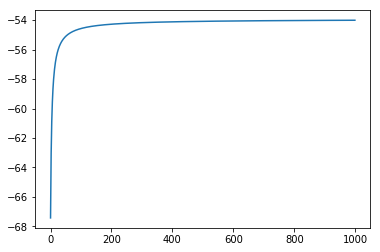

In [409]:
plt.figure(1)
plt.plot(energy_history)

In [255]:
a_i = np.random.normal(1,1,m)
a_i

array([0.04464954])

In [412]:
norm**2*k_grad

-4.2612483662156355e-07

In [378]:
k

88.84626584923089

In [291]:
k_grad_T(a_i,norm,l,k)

5.906907552881668e-10

In [292]:
k_grad_1_r(a_i,norm,l,k)

-9.451052084610668e-09

In [341]:
-Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)

1.4402762868157066

In [342]:
k -= -Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)
k

49.02484608813197

In [343]:
for i in range(10000):
    k += -Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)/2 
    if i%1000==0:
        print( k )
        print( -Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)/2 ) 

49.115277707152316
0.08423203582920458
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15
50.46512237494758
2.886579864025407e-15


In [340]:
-Z*hbarc*alpha*true_k_grad_1_r(a_i,norm,l,k) - hbarc**2/me * true_k_grad_T(a_i,norm,l,k)/2

-2.4424906541753444e-15

In [400]:
k_vec = []
for k_j in range(10,80):
    k_vec.append( (-Z*hbarc*alpha*expectation_1_r(a_i,get_norm(a_i,k_j,l),l,k_j)*m - hbarc**2/me * expectation_T(a_i,get_norm(a_i,k_j,l),l,k_j)*(2*m-1)/2 )*norm**2)

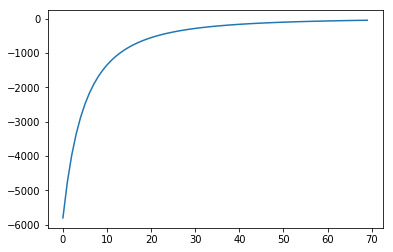

In [401]:
plt.plot(k_vec)

In [339]:
k_grad_norm(a_i,k,l)

0.09895801733536921

In [295]:
norm

670.9955006800835

In [360]:
k_j = 50
-Z*hbarc*alpha*true_k_grad_1_r(a_i,get_norm(a_i,k_j,l),l,k_j) - hbarc**2/me * true_k_grad_T(a_i,get_norm(a_i,k_j,l),l,k_j)/2

-0.013296564886795093

In [431]:
abs(34.4-37.2255585808052)/34.4

0.08213833083736048

In [76]:
abs(25.8)/34.4

0.75